In [1]:
from collections import Counter
import itertools
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 50)

In [37]:
import xgboost as xgb
from xgboost import plot_tree 
import matplotlib.pyplot as plt

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
from statistic import Statistic
from utils import UtilsKy
from analyzer import HelperAnalyzer, AnalyzerPrediction

In [5]:
# for autoreload modules
%load_ext autoreload
%autoreload 2

In [8]:
# kyw3
path_data = '/mnt/files/workdata/work/merchants/merchant_33_kyw3_2020-06-05/04_experiments/ex_01_some_teach/'
db_teach = pd.read_csv(UtilsKy.DB_TEACH_KYW3, dtype=str, encoding='cp1251')
db_test = pd.read_csv(UtilsKy.DB_TEST_KYW3, dtype=str, encoding='cp1251')
white = pd.read_csv(UtilsKy.WHITE_KYW3 , dtype=str)

In [9]:
# ky9
# path_data = '/mnt/files/workdata/work/merchants/merchant_32_ky9_2020-05-12_white_visa/04_experiments/'
# db_teach = pd.read_csv(UtilsKy.DB_TEACH_KY9, dtype=str)
# db_test = pd.read_csv(UtilsKy.DB_TEST_KY9, dtype=str)
# white = pd.read_csv(UtilsKy.WHITE_KY9 , dtype=str)

# for prod
# db_teach = pd.read_csv(UtilsKy.DB_TEACH_KY9_FOR_PROD, dtype=str)
# db_test = pd.read_csv(UtilsKy.DB_TEST_KY9_FOR_PROD , dtype=str)
# white = pd.read_csv(UtilsKy.WHITE_KY9 , dtype=str)

# db_teach = pd.read_csv(path_data + 'ex_05_ky9_xgb_jupiter_2020_07_08/db_teach_ky9_is_frequency_ip.csv', dtype=str)
# db_test = pd.read_csv(path_data + 'ex_05_ky9_xgb_jupiter_2020_07_08/db_test_ky9_is_frequency_ip.csv', dtype=str)

In [10]:
db_teach.columns

Index(['amount', 'amount_deviation', 'bank_currency', 'bin', 'city',
       'count_months_to_end_card', 'day_of_week', 'gender2', 'hour', 'id',
       'is_city_resolved', 'is_gender_undefined', 'latitude', 'longitude',
       'order_id', 'phone_2_norm', 'status'],
      dtype='object')

In [11]:
Statistic.get_table_value_counts(db_teach, 'status')

0    427164
1      6261
Name: status, dtype: int64

In [12]:
Statistic.get_table_value_counts(db_test, 'status')

0    58107
1      755
Name: status, dtype: int64

In [13]:
COL_FACTORS = ['bin', 'amount', 'bank_currency', 'hour', 'day_of_week', 'longitude', 'latitude', 'phone_2_norm', 'is_gender_undefined', 'is_city_resolved']
COL_FACTORS = sorted(COL_FACTORS)

In [14]:
# For Xgboost
from helper import DataHelper
datahelper = DataHelper(db_teach, db_test, COL_FACTORS)
datahelper.create_train_test()
datahelper.show_columns_with_na()
mean_values = datahelper.get_mean_value()
replaced_values = { col: mean_values[col] for col in ('latitude', 'longitude')}
replaced_values['default'] =  -999
datahelper.replaced_na_values(replaced_values)   
train , test = datahelper.get_train_test()

Statistic na values in columns : 
train na columns : Index(['latitude', 'longitude'], dtype='object')
latitude_na: 1537,longitude_na: 1537
test na columns : Index(['latitude', 'longitude'], dtype='object')
latitude_na: 63,longitude_na: 63
Replaced na values:
phone_2_norm_na -> -999
is_city_resolved_na -> -999
amount_na -> -999
latitude_na -> 36.90237577890762
bank_currency_na -> -999
day_of_week_na -> -999
is_gender_undefined_na -> -999
hour_na -> -999
longitude_na -> -92.53325861542274
bin_na -> -999


In [15]:
str(list(train))

"['amount', 'bank_currency', 'bin', 'day_of_week', 'hour', 'is_city_resolved', 'is_gender_undefined', 'latitude', 'longitude', 'phone_2_norm']"

In [16]:
train = train.values
test = test.values
label = db_teach.status.astype(int)

In [18]:
analyzer_prediction =  AnalyzerPrediction(db_teach, db_test, white) 

In [19]:
result_df_amount = None
# weight = analyzer_prediction.get_xgb_weight()

In [24]:
# Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
# This method using instead sample_weight 
scale_pos_weight = round(427164/6261, 3)

# Kyw3
max_depths =[3, 5]
n_rounds = [65, 87, 110]
etas = [0.2, 0.35]

# Best iter Kyw3
# 5-75-0.05  
# 3-87-0.35

# Ky9
# max_depths =[5]
# nrounds = [70, 90]
# etas = [0.35, 0.4]

In [32]:
# eval_metric = 'auc', it needs only for eval_set scoring
for eta, max_depth, n_round in itertools.product(etas, max_depths, n_rounds):
    config = {'max_depth': max_depth, 'learning_rate': eta, 'n_estimators': n_round}
    
    model = xgb.XGBClassifier(**config, use_label_encoder=False, disable_default_eval_metric=True, scale_pos_weight=scale_pos_weight)

    model.fit(train, label.astype(int))# sample_weight=weight)

    test_pred = model.predict_proba(test)
    db_test["probability"] = test_pred[:, 1]

    description = '-' . join([str(elem) for elem in (max_depth, n_round, eta)])                    
    result_df_amount = analyzer_prediction.get_table_prediction(description=description, result_df=result_df_amount, metric="count")

In [33]:
n = result_df_amount.shape[0]
sub_rows = list(range(n))[::2]
stat_best = result_df_amount.copy().iloc[sub_rows,:]

col_names = [col for col in stat_best.columns if col.startswith('p_') ] 
stat_best.loc[:, col_names] = stat_best.loc[:, col_names].astype(float)
stat_best = stat_best.sort_values(by="rating", ascending=False)

In [34]:
data_st = {'features': COL_FACTORS, 'rating': model.feature_importances_}
pd.DataFrame(data=data_st).sort_values(by=['rating'], ascending=False)

,features,rating
2,bin,0.141621
1,bank_currency,0.121767
6,is_gender_undefined,0.115782
9,phone_2_norm,0.111496
7,latitude,0.102300
0,amount,0.101146
8,longitude,0.096027
4,hour,0.077316
5,is_city_resolved,0.073387
3,day_of_week,0.059158


In [35]:
stat_best.iloc[:,:11]

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating
6,5-65-0.2,6.23,9.14,13.51,16.42,19.47,23.05,26.49,31.66,51.79,197.76
0,3-65-0.2,7.15,11.26,13.77,16.42,19.34,22.91,24.90,31.92,49.40,197.07
2,3-87-0.2,7.68,10.86,13.25,16.42,19.74,22.12,25.70,32.85,47.95,196.57
12,3-65-0.35,8.21,10.73,14.04,17.09,20.00,22.12,24.11,29.40,48.74,194.44
4,3-110-0.2,7.02,10.33,12.58,15.89,19.07,21.59,24.90,32.98,47.95,192.31
8,5-87-0.2,5.17,7.15,12.32,14.97,17.75,21.32,25.83,32.19,53.25,189.95
10,5-110-0.2,5.30,8.48,11.92,13.77,18.41,21.72,24.24,32.05,53.77,189.66
16,3-110-0.35,6.89,8.87,11.26,15.36,18.68,21.72,23.58,29.80,50.73,186.89
14,3-87-0.35,7.42,9.01,12.05,15.76,18.68,21.85,22.91,29.54,49.54,186.76
18,5-65-0.35,4.50,6.62,9.80,11.66,14.83,16.69,20.40,29.01,50.20,163.71


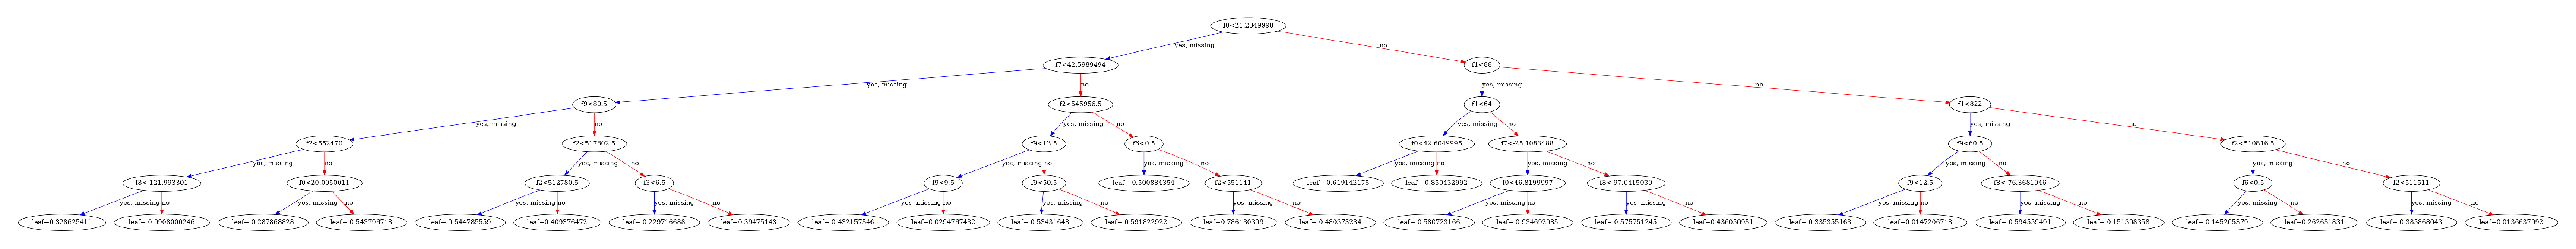

In [52]:
fig = plt.figure(dpi=380, figsize=(20, 15))
ax = plt.subplot(1,1,1)
plot_tree(model, num_trees=4, ax = ax)

In [93]:
# stat_best.iloc[:,:11] # Kyw3 without sum p_6 and p_7

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating
52,3-90-0.2-is_city_resolved-is_gender_undef,9.07,14.38,15.73,19.90,22.01,23.56,25.79,30.69,42.82,154.60
34,3-80-0.35-is_fr_net-is_gender_undef,7.20,17.02,18.59,19.83,20.96,21.31,23.38,26.68,42.36,152.64
38,3-90-0.35-is_fr_net-is_gender_undef,7.20,16.80,18.59,19.83,20.71,21.21,23.36,27.17,41.70,152.00
48,3-80-0.2-is_city_resolved-is_gender_undef,7.34,13.32,15.53,19.15,21.86,23.51,25.75,30.83,43.47,151.50
40,3-80-0.2-is_gender_undef,7.99,14.26,17.23,19.20,19.24,23.05,23.28,27.74,43.46,149.12
44,3-90-0.2-is_gender_undef,9.09,12.50,17.48,19.20,20.26,22.23,22.63,27.44,42.20,148.17
36,3-90-0.2-is_fr_net-is_gender_undef,7.71,12.42,15.79,18.83,21.75,24.04,24.70,29.90,41.34,147.74
32,3-80-0.2-is_fr_net-is_gender_undef,6.44,10.39,16.05,19.14,21.45,23.29,24.84,30.78,42.64,146.89
60,3-90-0.2-is_fr_net-is_city_resolved-is_gender_undef,5.64,10.66,16.80,18.97,20.86,22.31,25.15,30.71,40.79,144.43
56,3-80-0.2-is_fr_net-is_city_resolved-is_gender_undef,5.39,10.62,14.70,18.35,20.59,21.91,24.04,28.01,43.85,141.51
